In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)


sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cpu
cpu


## 数据加载

- 采用WMT16的德语和英语平行语料库，数据集主页：[WMT16](https://www.statmt.org/wmt16/multimodal-task.html#task1)


In [2]:
#和jieba分词类似
# !pip install sacremoses
# !pip install subword-nmt
# # BPE分词


In [3]:
!sh data_multi30k.sh wmt16 de en
#该代码的作用是运行 data_multi30k.sh 脚本，处理 WMT16 版本的 Multi30K 数据集，并将数据从德语（de）翻译成英语（en）。具体操作可能包括数据下载、预处理、格式转换等，具体取决于脚本的实现。

Finished applying bpe to train files.
Finished applying bpe to val files.
Finished applying bpe to test files.


Traceback (most recent call last):
  File "F:\python2025\python\day31\data_multi30k.py", line 16, in <module>
    from tqdm import tqdm
ModuleNotFoundError: No module named 'tqdm'

100%|##########| 10000/10000 [00:09<00:00, 1031.05it/s]


Dataset

In [6]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

class LangPairDataset(Dataset):

    def __init__(
        self, mode="train", max_length=128, overwrite_cache=False, data_dir="wmt16",
    ):
        self.data_dir = Path(data_dir)
        cache_path = self.data_dir / ".cache" / f"de2en_{mode}_{max_length}.npy"

        if overwrite_cache or not cache_path.exists():
            cache_path.parent.mkdir(parents=True, exist_ok=True)

            with open(self.data_dir / f"{mode}_src.bpe", "r", encoding="utf8") as file:
                self.src = file.readlines() # 读取源语言文件所有行

            with open(self.data_dir / f"{mode}_trg.bpe", "r", encoding="utf8") as file:
                self.trg = file.readlines() # 读取目标语言文件所有行

            filtered_src = []
            filtered_trg = []
            # max length filter,超出最大长度的句子舍弃
            for src, trg in zip(self.src, self.trg):
                if len(src) <= max_length and len(trg) <= max_length: # 过滤长度超过最大长度的句子
                    filtered_src.append(src.strip()) # 去掉句子前后的空格
                    filtered_trg.append(trg.strip())
            filtered_src = np.array(filtered_src)
            filtered_trg = np.array(filtered_trg)
            np.save(
                cache_path,
                {"src": filtered_src, "trg": filtered_trg },
                allow_pickle=True,
            )#allow_pickle=True允许保存对象数组，将过滤后的数据保存为 NumPy 数组，存储在缓存文件中
            print(f"save cache to {cache_path}")

        else:
            cache_dict = np.load(cache_path, allow_pickle=True).item() #allow_pickle=True允许保存对象数组
            print(f"load {mode} dataset from {cache_path}")
            filtered_src = cache_dict["src"]
            filtered_trg = cache_dict["trg"]

        self.src = filtered_src
        self.trg = filtered_trg

    def __getitem__(self, index):
        return self.src[index], self.trg[index]

    def __len__(self):
        return len(self.src)


train_ds = LangPairDataset("train")#训练集
val_ds = LangPairDataset("val")#验证集

save cache to wmt16\.cache\de2en_train_128.npy
save cache to wmt16\.cache\de2en_val_128.npy


In [8]:
# !rm wmt16/.cache -r  #删除缓存文件

In [9]:
len(train_ds) #少了1000多个样本

27659

In [10]:
print("source: {}\ntarget: {}".format(*train_ds[-1])) #查看最后一个样本

source: ein älterer mann sitzt mit einem jungen mit einem wagen vor einer fassade .
target: an elderly man sits outside a storefront accompani@@ ed by a young boy with a cart .


### Tokenizer

这里有两种处理方式，分别对应着 encoder 和 decoder 的 word embedding 是否共享，这里实现共享的方案

In [28]:
#载入词表，看下词表长度，词表就像英语字典,构建word2idx和idx2word
word2idx = {
    "[PAD]": 0,     # 填充 token
    "[BOS]": 1,     # begin of sentence
    "[UNK]": 2,     # 未知 token
    "[EOS]": 3,     # end of sentence
}# 初始化词表，包括填充、开始、未知和结束符号，这里的索引是从0开始的，所以总共是4个符号
idx2word = {value: key for key, value in word2idx.items()}#反向构建词表，方便索引到单词的映射
index = len(idx2word)# 计算词表长度，即索引从0开始，所以总共是4个符号
threshold = 1  # 出现次数低于此的token舍弃

with open("wmt16/vocab", "r", encoding="utf8") as file:
    for line in tqdm(file.readlines()):
        token, counts = line.strip().split()# 按空格分割，得到单词和出现次数
        if int(counts) >= threshold:
            word2idx[token] = index# 出现次数大于等于阈值的单词加入词表
            idx2word[index] = token# 反向构建词表，方便索引到单词的映射
            index += 1

vocab_size = len(word2idx)
print("vocab_size: {}".format(vocab_size))

  0%|          | 0/9714 [00:00<?, ?it/s]

vocab_size: 9718


In [12]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=128, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """如果padding_first == True，则padding加载前面，否则加载后面"""
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))
        indices_list = []
        for text in text_list:
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]]
            if add_bos:
                indices = [self.bos_idx] + indices
            if add_eos:
                indices = indices + [self.eos_idx]
            if padding_first:
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:
                indices = indices + [self.pad_idx] * (max_length - len(indices))
            indices_list.append(indices)
        input_ids = torch.tensor(indices_list)
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64) # 为了方便损失计算，这里的mask为0的地方需要计算，为1的地方不需要计算
        return input_ids if not return_mask else (input_ids, masks)


    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break
                text.append(word)
            text_list.append(" ".join(text) if not split else text)
        return text_list


tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)

tokenizer.encode([["hello"], ["hello", "world"]], add_bos=True, add_eos=False)
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices = tokenizer.encode(raw_text, padding_first=False, add_bos=True, add_eos=True)
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)
print("raw text")
for raw in raw_text:
    print(raw)
print("indices")
for index in indices:
    print(index)
print("decode text")
for decode in decode_text:
    print(decode)

raw text
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
indices
tensor([   1,    2, 4517,    3,    0,    0,    0])
tensor([   1,    2, 7167,    2,   22,    2,    3])
tensor([   1,  425,   18,    5, 4493,    3,    0])
decode text
[BOS] [UNK] world [EOS] [PAD] [PAD] [PAD]
[BOS] [UNK] text [UNK] with [UNK] [EOS]
[BOS] this is a test [EOS] [PAD]


In [13]:
for i,j in train_ds:
    print(len(i))
    print(len(j))
    break

72
54


### Transformer Batch Sampler

> Sentence pairs were batched together by approximate sequence length. Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens
句子按照序列长度差不多的分到一个批次。 每个训练批次包含一组句子对，其中包含大约 25000 个源标记和 25000 个目标标记

In [14]:
class SampleInfo: #下面的info对象
    def __init__(self, i, lens):
        """
        记录文本对的序号和长度信息
        输入：
            - i (int): 文本对的序号。
            - lens (list): 文本对源语言和目标语言的长度
        """
        self.i = i
        # 加一是考虑填补在文本前后的特殊词元，lens[0]和lens[1]分别表示源语言和目标语言的长度
        self.max_len = max(lens[0], lens[1]) + 1
        self.src_len = lens[0] + 1
        self.trg_len = lens[1] + 1

# 一个批量生成器，根据词元数目的限制来控制批量的大小。它会根据传入的样本信息，在不超过设定大小的情况下，逐步构建批量。
class TokenBatchCreator:
    def __init__(self, batch_size):
        """
        参数:
        batch_size (int): 用于限制批量的大小。
        功能:
        初始化了一个空的批量列表 _batch。
        设定了初始的最大长度为 -1。
        存储了传入的 batch_size。
        """

        self._batch = []  #这个就是之前的batch_size，就是第一个batch内有多少个样本
        self.max_len = -1
        self._batch_size = batch_size # 限制批量的大小,假设是4096

    def append(self, info):
        """
        参数:
        info (SampleInfo): 文本对的信息。
        功能:
        接收一个 SampleInfo 对象，并根据其最大长度信息更新当前批量的最大长度。
        如果将新的样本加入批量后超过了批量大小限制，它会返回已有的批量并将新的样本加入新的批量。
        否则，它会更新最大长度并将样本添加到当前批量中。
        """
        # 更新当前批量的最大长度
        cur_len = info.max_len # 当前样本的长度
        max_len = max(self.max_len, cur_len) # 每来一个样本，更新当前批次的最大长度
        # 如果新的样本加入批量后超过大小限制，则将已有的批量返回，新的样本加入新的批量
        if max_len * (len(self._batch) + 1) > self._batch_size:
            self._batch, result = [], self._batch # 保存当前的batch，并返回,这里的result是之前的batch,_batch清空
            self._batch.append(info) #箱子里的第一条样本，放入
            self.max_len = cur_len #因为是当前batch的第一个样本，所以它的长度就是当前长度
            return result
        else:
            self.max_len = max_len
            self._batch.append(info) # 将样本添加到当前批量中
            return None

    @property
    def batch(self):
        return self._batch

In [15]:
from torch.utils.data import BatchSampler
import numpy as np


class TransformerBatchSampler(BatchSampler):
    def __init__(self,
                 dataset,
                 batch_size,
                 shuffle_batch=False,
                 clip_last_batch=False,
                 seed=0):
        """
        批量采样器
        输入:
            - dataset: 数据集
            - batch_size: 批量大小
            - shuffle_batch: 是否对生成的批量进行洗牌
            - clip_last_batch: 是否裁剪最后剩下的数据
            - seed: 随机数种子
        """
        self._dataset = dataset
        self._batch_size = batch_size
        self._shuffle_batch = shuffle_batch
        self._clip_last_batch = clip_last_batch
        self._seed = seed
        self._random = np.random
        self._random.seed(seed)

        self._sample_infos = []
        # 根据数据集中的每个样本，创建了对应的 SampleInfo 对象，包含了样本的索引和长度信息。
        for i, data in enumerate(self._dataset):
            lens = [len(data[0]), len(data[1])] #输入和输出的长度计算放到lens中
            self._sample_infos.append(SampleInfo(i, lens))

    def __iter__(self):
        """
        对数据集中的样本进行排序，排序规则是先按源语言长度排序，如果相同则按目标语言长度排序。
        使用 TokenBatchCreator 逐步组装批量数据，当满足批量大小时返回一个批量的样本信息。
        如果不裁剪最后一个批次的数据且存在剩余样本，则将这些样本组成最后一个批次。
        如果需要对批量进行洗牌，则对批次进行洗牌操作。
        通过迭代器，抛出每个批量的样本在数据集中的索引。
        """
        # 排序，如果源语言长度相同则按照目标语言的长度排列
        infos = sorted(self._sample_infos,
                       key=lambda x: (x.src_len, x.trg_len))
        # 组装批量，所有的batch都放入batch_infos
        batch_infos = []
        batch_creator = TokenBatchCreator(self._batch_size) # 批量生成器
        for info in infos:
            batch = batch_creator.append(info)
            # 存够一个batch的样本信息后，会把这个batch返回，否则返回为None
            if batch is not None:
                batch_infos.append(batch)

        # 是否抛弃最后批量的文本对
        if not self._clip_last_batch and len(batch_creator.batch) != 0:
            batch_infos.append(batch_creator.batch) # 最后一个batch

        # 打乱batch
        if self._shuffle_batch:
            self._random.shuffle(batch_infos)

        self.batch_number = len(batch_infos)
        # print(self.batch_number) #为了理解

        # 抛出一个批量的文本对在数据集中的序号
        for batch in batch_infos:
            batch_indices = [info.i for info in batch] # 批量的样本在数据集中的索引，第一个batch[0,1,.....82]，第二个batch[83,84,85,86,87]
            yield batch_indices

    def __len__(self):
        """
        返回批量的数量
        """
        if hasattr(self, "batch_number"):
            return self.batch_number
        # 计算批量的数量,没有用到下面的情况，不用看
        batch_number = (len(self._dataset) +
                        self._batch_size) // self._batch_size
        return batch_number

In [16]:
sampler = TransformerBatchSampler(train_ds, batch_size=4096, shuffle_batch=True)

#为什么这里每个批量的样本对数目不一样呢？长度*batch_number>4096的时候，就会返回上一个batch，然后新的样本加入新的batch,具体要看TokenBatchCreator的44行

In [17]:
for idx, batch in enumerate(sampler):
    print("第{}批量的数据中含有文本对是：{}，数量为：{}".format(idx, batch, len(batch)))
    if idx >= 3:
        break

第0批量的数据中含有文本对是：[20303, 272, 3549, 11130, 12595, 12784, 13559, 22464, 1474, 6750, 7174, 8451, 10507, 15759, 16727, 19970, 25362, 27342, 27467, 2093, 2953, 3053, 4811, 6859, 10441, 10853, 11970, 15839, 16938, 18233, 20382, 21262, 24568, 14, 1067, 4934, 10278, 11027, 11753, 12988, 15029, 15900, 16219, 16799, 19208, 20018, 21926, 2490, 2565, 2854, 3903, 6469, 8006, 9892, 10241, 10400, 11697, 13678, 17015, 19819, 20660, 23208, 25640, 4620, 5719, 7807, 9474, 11360, 11423, 11857, 12519, 14495, 16832, 17204, 17214, 22914, 23865, 25037, 26610, 27438, 365, 1063, 3404]，数量为：83
第1批量的数据中含有文本对是：[1896, 2650, 5347, 6855, 13019, 14422, 15533, 17704, 20935, 21794, 27107, 2422, 5213, 6555, 6638, 7682, 7902, 14492, 19817, 20186, 20941, 21052, 21164, 21222, 23422, 23573, 23834, 24516, 24599, 528, 933, 5364, 7649, 8029, 12179, 16073, 17508, 17732, 20361, 21449, 25890, 26193, 26438, 1469, 5758, 9238, 10232, 16510, 17373]，数量为：49
第2批量的数据中含有文本对是：[6311, 19570, 21049, 21560, 24196, 24600, 12012, 12977, 23611, 2491

In [18]:
len(sampler)#总共的batch数量

533

### DataLoader

In [19]:
def collate_fct(batch, tokenizer):
    src_words = [pair[0].split() for pair in batch]
    trg_words = [pair[1].split() for pair in batch]

    # [BOS] src [EOS] [PAD]
    encoder_inputs, encoder_inputs_mask = tokenizer.encode(
        src_words, padding_first=False, add_bos=True, add_eos=True, return_mask=True
        )

    # [BOS] trg [PAD]
    decoder_inputs = tokenizer.encode(
        trg_words, padding_first=False, add_bos=True, add_eos=False, return_mask=False,
        )

    # trg [EOS] [PAD]
    decoder_labels, decoder_labels_mask = tokenizer.encode(
        trg_words, padding_first=False, add_bos=False, add_eos=True, return_mask=True
        )

    return {
        "encoder_inputs": encoder_inputs.to(device=device),
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device),
        "decoder_inputs": decoder_inputs.to(device=device),
        "decoder_labels": decoder_labels.to(device=device),
        "decoder_labels_mask": decoder_labels_mask.to(device=device),
    }


In [20]:
from functools import partial # 固定collate_fct的tokenizer参数

#可以调整batch_size,来看最终的bleu
sampler = TransformerBatchSampler(train_ds, batch_size=256, shuffle_batch=True)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
sample_dl = DataLoader(train_ds, batch_sampler=sampler, collate_fn=partial(collate_fct, tokenizer=tokenizer)) #partial函数，固定collate_fct的tokenizer参数

for batch in sample_dl:
    for key, value in batch.items():
        print(key)
        print(value)
    break

encoder_inputs
tensor([[   1,    7,   17,    6,    8,   89,  157,   73,    7,  541,  255,    9,
           14,   42,  153,  119, 1481,  406, 2384, 1319,    4,    3],
        [   1,  521,    6,    8,  808, 1299, 2305, 1638, 2535,  184,   31, 1735,
          961,   55, 1732,    4,    3,    0,    0,    0,    0,    0]])
encoder_inputs_mask
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]])
decoder_inputs
tensor([[   1,    5,   16,    6,    5,   50,   41,   18,   78,    5,  421,  254,
         7050,  106,  471,    4],
        [   1,  452,    6,    5, 5010, 1118, 1010,  106,    5,  517, 5103,    4,
            0,    0,    0,    0]])
decoder_labels
tensor([[   5,   16,    6,    5,   50,   41,   18,   78,    5,  421,  254, 7050,
          106,  471,    4,    3],
        [ 452,    6,    5, 5010, 1118, 1010,  106,    5,  517, 5103,    4,    3,
            0,    0,    0,    0]])
decoder_labels_ma

## 定义模型

- Transformer模型由Embedding、Transformer-Block组成
- Embedding包括：
    - WordEmbedding
    - PositionEmbedding
- Transformer-Block包括：
    - Self-Attention
    - Cross-Attention
    - MLP

### Embedding

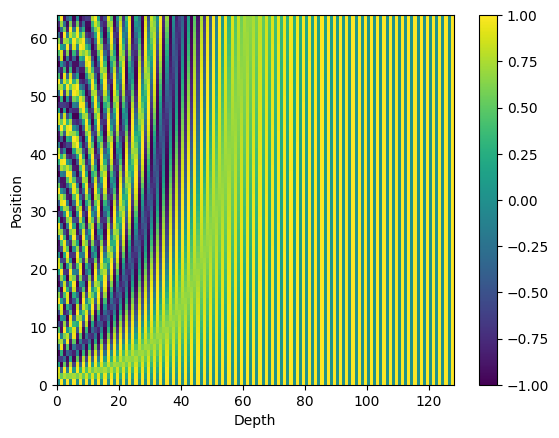

In [21]:

class TransformerEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.vocab_size = config["vocab_size"]
        self.hidden_size = config["d_model"] # 词向量维度
        self.pad_idx = config["pad_idx"]
        dropout_rate = config["dropout"]
        self.max_length = config["max_length"]

        # layers,设置padding_idx可以让pad的词向量全为0
        self.word_embedding = nn.Embedding(
            self.vocab_size, self.hidden_size, padding_idx=self.pad_idx
        )
        self.pos_embedding = nn.Embedding(
            self.max_length,
            self.hidden_size,
            _weight=self.get_positional_encoding(
                self.max_length, self.hidden_size
            ),# 位置编码，权重通过get_positional_encoding函数计算得到
        )
        self.pos_embedding.weight.requires_grad_(False) # 不更新位置编码的权重
        self.dropout = nn.Dropout(dropout_rate) # 随机失活层

    def get_word_embedding_weights(self):
        return self.word_embedding.weight

    # 计算位置信息
    @classmethod
    def get_positional_encoding(self, max_length, hidden_size):#max_length是最大长度，hidden_size是embedding维度相等
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_length, hidden_size) # 初始化位置编码
        # .unsqueeze(1) 是将这个一维张量转换为二维张量，即将其形状从 (max_length,) 变为 (max_length, 1)。这个操作在张量的维度上增加了一个维度，使其从一维变为二维，第二维的大小为 1。
        position = torch.arange(0, max_length).unsqueeze(1) # 位置信息,从0到max_length-1
        div_term = torch.exp(
            torch.arange(0, hidden_size, 2)
            * -(torch.log(torch.Tensor([10000.0])) / hidden_size)
        )# 计算位置编码的权重,为了性能考量（是数学上的对数函数分解）
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, input_ids):
        # input_ids: [batch_size, seq_len]
        seq_len = input_ids.shape[1]
        assert (
            seq_len <= self.max_length
        ), f"input sequence length should no more than {self.max_length} but got {seq_len}"

        position_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        print(position_ids)
        # embedding
        word_embeds = self.word_embedding(input_ids) # 词嵌入
        pos_embeds = self.pos_embedding(position_ids) # 位置编码
        embeds = word_embeds + pos_embeds
        embeds = self.dropout(embeds)

        return embeds


def plot_position_embedding(position_embedding):# 绘制位置编码
    plt.pcolormesh(position_embedding) # 绘制位置编码矩阵
    plt.xlabel('Depth')
    plt.ylabel('Position')
    plt.colorbar() # 颜色条，-1到1的颜色范围
    plt.show()

position_embedding = TransformerEmbedding.get_positional_encoding(64, 128)
plot_position_embedding(position_embedding)


In [22]:
#随机input，调用TransformerEmbedding
config={
    "vocab_size": 100,
    "d_model": 128,
    "pad_idx": 0,
    "max_length": 64,
    "dropout": 0.1,
}# 随机生成input_ids，维度是[batch_size, seq_len]
input_ids = torch.randint(0, 100, (2, 50))
embeds = TransformerEmbedding(config)(input_ids)# 调用TransformerEmbedding，返回嵌入后的结果
embeds.shape

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])


torch.Size([2, 50, 128])

### Transformer Block

#### scaled-dot-product-attention

In [23]:
from dataclasses import dataclass
from typing import Optional, Tuple

Tensor = torch.Tensor

@dataclass
class AttentionOutput:
    hidden_states: Tensor
    attn_scores: Tensor

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.hidden_size = config["d_model"] # 隐藏层大小
        self.num_heads = config["num_heads"] # 多头注意力的头数
        assert (
            self.hidden_size % self.num_heads == 0
        ), "Hidden size must be divisible by num_heads but got {} and {}".format(
            self.hidden_size, self.num_heads
        )
        self.head_dim = self.hidden_size // self.num_heads # 每个头的维度

        # layers
        self.Wq = nn.Linear(self.hidden_size, self.hidden_size, bias=False) #第二个self.hidden_size可以*系数
        self.Wk = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.Wv = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.Wo = nn.Linear(self.hidden_size, self.hidden_size, bias=False) # 输出层

    def _split_heads(self, x: Tensor) -> Tensor:
        bs, seq_len, _ = x.shape #假设输入的维度是[batch_size, seq_len, hidden_size],hidden_size是512
        x = x.view(bs, seq_len, self.num_heads, self.head_dim) #num_heads是8，head_dim是64
        return x.permute(0, 2, 1, 3) #变换维度，[batch_size, num_heads, seq_len, head_dim]

    def _merge_heads(self, x: Tensor) -> Tensor:#将多头注意力的输出合并为一个张量
        bs, _, seq_len, _ = x.shape #假设输入的维度是[batch_size, num_heads, seq_len, head_dim]
        return x.permute(0, 2, 1, 3).reshape(bs, seq_len, self.hidden_size) # 变换维度，变为[batch_size, seq_len, hidden_size]

    def forward(self, querys, keys, values, attn_mask=None) -> AttentionOutput:
        # split heads
        querys = self._split_heads(self.Wq(querys)) #(batch_size, seq_len,hidden_dim)-->[batch_size, num_heads, seq_len, head_dim]
        keys = self._split_heads(self.Wk(keys))#[batch_size, num_heads, seq_len, head_dim]
        values = self._split_heads(self.Wv(values))#[batch_size, num_heads, seq_len, head_dim]

        # calculate attention scores
        qk_logits = torch.matmul(querys, keys.mT) # 计算注意力分数，matmul是矩阵乘法，mT是矩阵转置,qk_logits是[batch_size, num_heads, seq_len, seq_len]
        # print(querys.shape[-2], keys.shape[-2])  #3 4
        if attn_mask is not None:
            attn_mask = attn_mask[:, :, : querys.shape[-2], : keys.shape[-2]]
            qk_logits += attn_mask * -1e9 # 给需要mask的地方设置一个负无穷
        attn_scores = F.softmax(qk_logits / (self.head_dim**0.5), dim=-1) # 计算注意力分数

        # apply attention scores
        embeds = torch.matmul(attn_scores, values) # softmax后的结果与value相乘，得到新的表示
        embeds = self.Wo(self._merge_heads(embeds)) # 输出层 [batch_size, seq_len, hidden_size]

        return AttentionOutput(hidden_states=embeds, attn_scores=attn_scores)

mha = MultiHeadAttention({"num_heads": 2, "d_model": 2})
query = torch.randn(2, 3, 2) # [batch_size, seq_len, hidden_size]
query /= query.norm(dim=-1, keepdim=True) # 归一化
key_value = torch.randn(2, 4, 2)
print(f'key_value.shape {key_value.shape}')
outputs = mha(query, key_value, key_value) #最终输出shape和query的shape一样
print(outputs.hidden_states.shape)
print(outputs.attn_scores.shape)

key_value.shape torch.Size([2, 4, 2])
torch.Size([2, 3, 2])
torch.Size([2, 2, 3, 4])


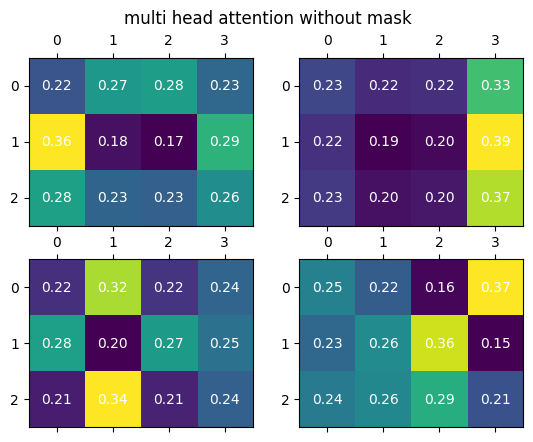

In [24]:
# plt.subplots() 用于创建子图网格，其维度基于 outputs.attn_scores.shape[:2]。子图的行数和列数似乎由 outputs.attn_scores 的前两个维度确定。
fig, axis = plt.subplots(*outputs.attn_scores.shape[:2])
for i in range(query.shape[0]):
    for j in range(outputs.attn_scores.shape[1]):
        # axis[i, j].matshow(outputs.attn_scores[i, j].detach().numpy())：此行使用 Matplotlib 的 matshow 绘制每个 i 和 j 的注意力分数热图。detach().numpy() 将 PyTorch 张量转换为 NumPy 数组以进行可视化。
        axis[i, j].matshow(outputs.attn_scores[i, j].detach().numpy())
        for x in range(outputs.attn_scores.shape[2]):
            for y in range(outputs.attn_scores.shape[3]):
                # axis[i, j].text(y, x, f"{outputs.attn_scores[i, j, x, y]:.2f}", ha="center", va="center", color="w")：此代码在热图上叠加文本，显示 (x, y) 位置处的注意力分数。格式化部分 f"{outputs.attn_scores[i, j, x, y]:.2f}" 确保以两位小数显示注意力分数。文本以白色居中显示在 (y, x) 坐标处。
                axis[i, j].text(y, x, f"{outputs.attn_scores[i, j, x, y]:.2f}", ha="center", va="center", color="w")
fig.suptitle("multi head attention without mask")
plt.show()

--------------------------------------------------


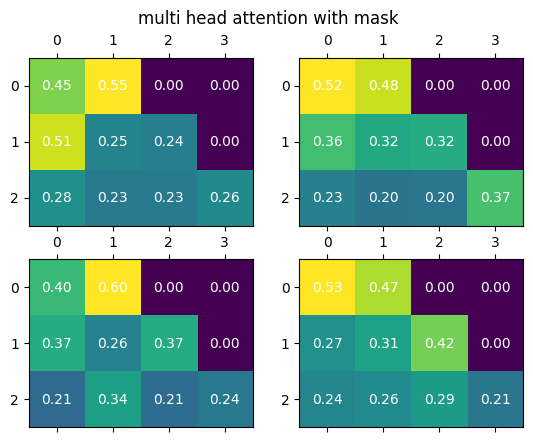

In [25]:
print('-'*50)
# mask
mask = torch.Tensor([[0, 0, 1, 1], [0, 0, 0, 1], [0, 0, 0, 0]]).reshape(1, 1, 3, 4) #手工构造mask
outputs_masked = mha(query, key_value, key_value, mask)

fig, axis = plt.subplots(*outputs_masked.attn_scores.shape[:2])
for i in range(query.shape[0]):
    for j in range(outputs_masked.attn_scores.shape[1]):
        axis[i, j].matshow(outputs_masked.attn_scores[i, j].detach().numpy())
        for x in range(outputs_masked.attn_scores.shape[2]):
            for y in range(outputs_masked.attn_scores.shape[3]):
                axis[i, j].text(y, x, f"{outputs_masked.attn_scores[i, j, x, y]:.2f}", ha="center", va="center", color="w")
fig.suptitle("multi head attention with mask")
plt.show()

#### Transformer-Block

In [26]:
# 通过使用 @dataclass 装饰器，Python 会自动为该类生成一些方法，如 __init__()、__repr__() 和 __eq__() 等，这些方法可以使类的使用更加方便。
@dataclass
class TransformerBlockOutput:
# hidden_states: Tensor：用于存储某个块产生的隐藏状态。
# self_attn_scores: Tensor：包含了自注意力机制（self-attention）所计算得到的注意力分数。
# cross_attn_scores: Optional[Tensor] = None：是一个可选字段，存储了交叉注意力（cross-attention）计算得到的注意力分数。这里的 Optional 表示这个字段可以是 Tensor 类型，也可以是 None。
    hidden_states: Tensor
    self_attn_scores: Tensor
    cross_attn_scores: Optional[Tensor] = None

class TransformerBlock(nn.Module):
    def __init__(self, config, add_cross_attention=False):
        super().__init__()
        # hyper params
        self.hidden_size = config["d_model"]
        self.num_heads = config["num_heads"]
        dropout_rate = config["dropout"]
        ffn_dim = config["dim_feedforward"]
        eps = config["layer_norm_eps"] # 层归一化的epsilon值

        # self-attention
        self.self_atten = MultiHeadAttention(config) # 多头注意力
        self.self_ln = nn.LayerNorm(self.hidden_size, eps=eps) #层归一化(层标准化)
        self.self_dropout = nn.Dropout(dropout_rate)

        # cross-attention，交叉注意力，decoder中使用,因此额外做一个判断
        if add_cross_attention:
            self.cross_atten = MultiHeadAttention(config)
            self.cross_ln = nn.LayerNorm(self.hidden_size, eps=eps)
            self.cross_dropout = nn.Dropout(dropout_rate)
        else:
            self.cross_atten = None

        # FFN,前馈神经网络
        self.ffn = nn.Sequential(
            nn.Linear(self.hidden_size, ffn_dim),
            nn.ReLU(),
            nn.Linear(ffn_dim, self.hidden_size),
        )
        self.ffn_ln = nn.LayerNorm(self.hidden_size, eps=eps)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(
        self,
        hidden_states,
        attn_mask=None,
        encoder_outputs=None,
        cross_attn_mask=None,
    ):
        # self-attention,自注意力
        self_atten_output = self.self_atten(
            hidden_states, hidden_states, hidden_states, attn_mask
        )
        self_embeds = self.self_ln(
            hidden_states + self.self_dropout(self_atten_output.hidden_states)
        ) #多头注意力进行dropout，然后和原始输入进行残差连接，然后进行层归一化

        # cross-attention，交叉注意力
        if self.cross_atten is not None:
            assert encoder_outputs is not None
            cross_atten_output = self.cross_atten(
                self_embeds, encoder_outputs, encoder_outputs, cross_attn_mask
            ) #query是self_embeds，key和value都是encoder_outputs
            cross_embeds = self.cross_ln(
                self_embeds + self.cross_dropout(cross_atten_output.hidden_states)
            ) # 交叉注意力进行dropout，然后和self_embeds进行残差连接，然后进行层归一化

        # FFN
        embeds = cross_embeds if self.cross_atten is not None else self_embeds # 如果有交叉注意力，则使用交叉注意力的输出作为FFN的输入；否则，使用self_embeds作为FFN的输入
        ffn_output = self.ffn(embeds) # 前馈神经网络
        embeds = self.ffn_ln(embeds + self.ffn_dropout(ffn_output)) # 前馈神经网络进行dropout，然后和原始输入进行残差连接，然后进行层归一化

        return TransformerBlockOutput(
            hidden_states=embeds,
            self_attn_scores=self_atten_output.attn_scores,
            cross_attn_scores=cross_atten_output.attn_scores
            if self.cross_atten is not None
            else None,
        )#返回一个TransformerBlockOutput对象，包含了隐藏状态、自注意力分数、交叉注意力分数。

#### Encoder

In [27]:
from typing import List

@dataclass
class TransformerEncoderOutput:
    last_hidden_states: Tensor
    attn_scores: List[Tensor]

# https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        # hyper params
        self.num_layers = config["num_encoder_layers"]

        # layers,仅仅是一个模块的列表，它本身没有定义前向传递（forward pass）过程。你需要在 forward 方法中明确地定义如何使用这些模块。
        self.layers = nn.ModuleList(
            [TransformerBlock(config) for _ in range(self.num_layers)]
        )

    def forward(
        self, encoder_inputs_embeds, attn_mask=None
    ) -> TransformerEncoderOutput:
        attn_scores = [] # 存储每个层的注意力分数
        embeds = encoder_inputs_embeds # 输入的嵌入向量作为第一层的输入(embedding+位置编码)
        for layer in self.layers:
            block_outputs = layer(embeds, attn_mask=attn_mask)
            embeds = block_outputs.hidden_states #上一层的输出作为下一层的输入
            # 在每个层的输出中，提取了隐藏状态 block_outputs.hidden_states，并将对应的注意力分数 block_outputs.self_attn_scores 添加到列表 attn_scores 中。
            attn_scores.append(block_outputs.self_attn_scores) # 存储每个层的注意力分数,用于画图

        return TransformerEncoderOutput(
            last_hidden_states=embeds, attn_scores=attn_scores
        )

